In [213]:
import pandas as pd               # For loading and handling data
import numpy as np                # For numerical operations
import matplotlib.pyplot as plt   # For charts and plots
import seaborn as sns             # For beautiful visualizations
from sklearn.model_selection import train_test_split  # For splitting dataset into training/testing
from sklearn.preprocessing import StandardScaler, LabelEncoder  # For preparing the data
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # Our models
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error  # For evaluation
import joblib                     # For saving our models
import os # To check or change working directory for file operations
print(os.getcwd())


e:\Projects\Employee Salary Prediction\salary_prediction


Info about dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31140 entries, 2 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             31140 non-null  int64
 1   workclass       31140 non-null  int32
 2   fnlwgt          31140 non-null  int64
 3   education       31140 non-null  int32
 4   marital_status  31140 non-null  int32
 5   occupation      31140 non-null  int32
 6   relationship    31140 non-null  int32
 7   race            31140 non-null  int32
 8   gender          31140 non-null  int32
 9   capital_gain    31140 non-null  int64
 10  capital_loss    31140 non-null  int64
 11  hours_per_week  31140 non-null  int64
 12  native_country  31140 non-null  int32
 13  income          31140 non-null  int32
 14  experience      31140 non-null  int32
dtypes: int32(10), int64(5)
memory usage: 2.6 MB

Summary of numeric features:
                age     workclass        fnlwgt     education

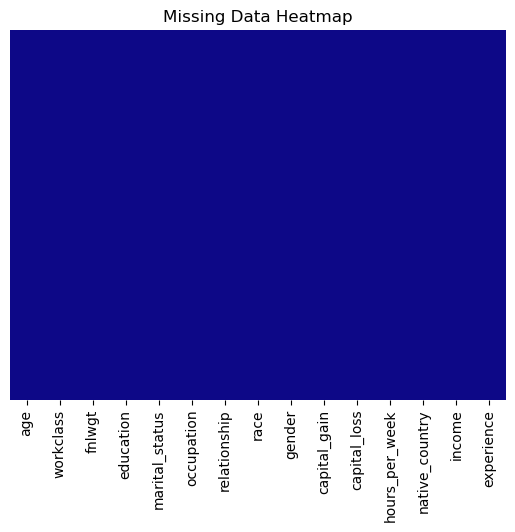

In [214]:
# Load the data
df=pd.read_csv("../data/raw/adult.csv")


# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace('.', '_',regex=False)  # ← cleaning column names
df.rename(columns={'sex': 'gender'}, inplace=True)  # ← renaming 'sex' to 'gender'

np.random.seed(42)  # So it's consistent every run

df['experience'] = np.random.randint(0, 40, size=len(df))

# Replacing '?' with 'Others' for selected columns
columns_to_clean = ['workclass', 'occupation', 'native_country']
for col in columns_to_clean:
    df[col] = df[col].replace('?', 'Others')

# Drop useless/low-info categories
df = df[~df['workclass'].isin(['Without-pay', 'Never-worked'])]
df = df[~df['education'].isin(['1st-4th', '5th-6th', 'Preschool'])]
df = df[(df['age'] >= 17) & (df['age'] <= 75)]
df = df[(df['hours_per_week'] >= 10) & (df['hours_per_week'] <= 80)]

df.drop(columns=['education_num'], inplace=True)  # ✅ This keeps 'education'


# Encoding categorical columns using LabelEncoder
from sklearn.preprocessing import LabelEncoder

categorical_cols = df.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoder for future use if needed

df.head(15)

# Explore basic info about the dataset
print("Info about dataset:")
df.info()

print("\nSummary of numeric features:")
print(df.describe())

print("\nCount of missing values:")
print(df.isnull().sum())

# Visualize missing values (if any)
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='plasma')
plt.title('Missing Data Heatmap')
plt.show()

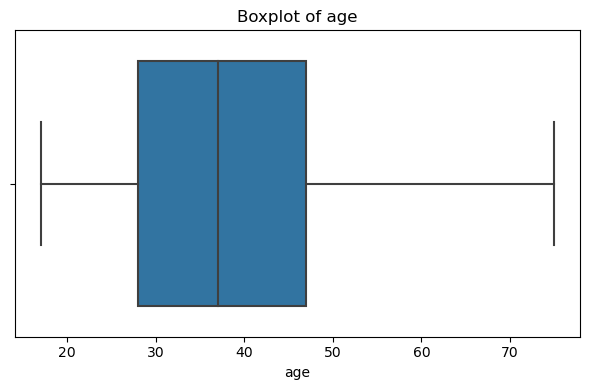

📌 age: 0 outliers detected


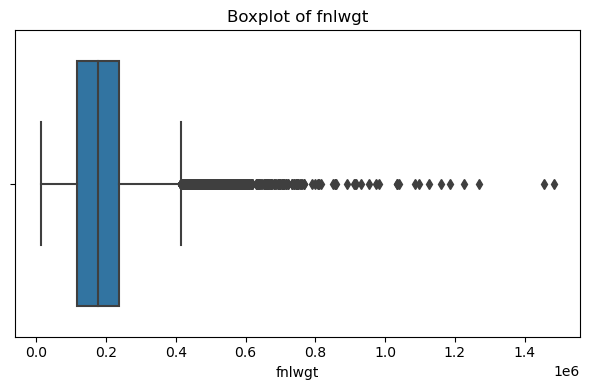

📌 fnlwgt: 943 outliers detected


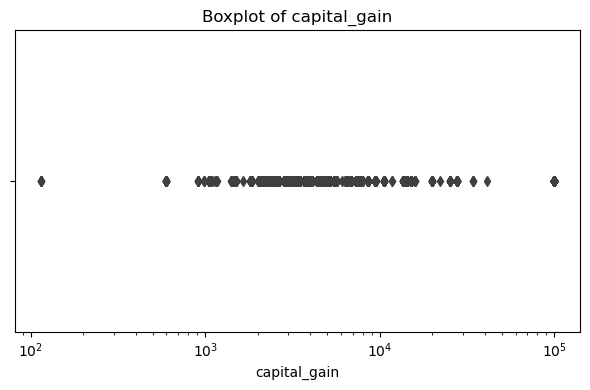

📌 capital_gain: 2613 outliers detected


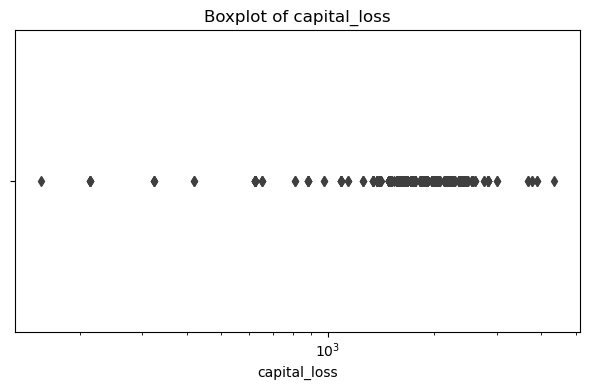

📌 capital_loss: 1468 outliers detected


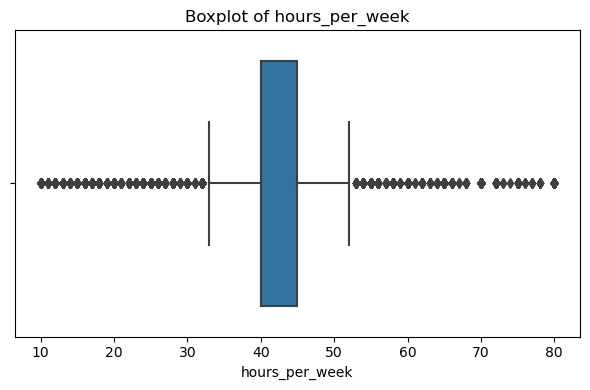

📌 hours_per_week: 8080 outliers detected


In [215]:
# Checking outliers using boxplots and printing outlier counts (IQR method)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    # Plot the boxplot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    
    # Optional: Apply log scale for skewed columns
    if col in ['capital_gain', 'capital_loss']:
        plt.xscale('log')
    
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()
    
    # Calculate and print number of outliers using IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_condition = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
    outliers = df[outlier_condition]
    print(f"📌 {col}: {len(outliers)} outliers detected")



In [216]:
# Remove age outliers: keep age between 17 and 75
df = df[(df['age'] >= 17) & (df['age'] <= 75)]

# Remove hours/week outliers (if needed)
df = df[(df['hours_per_week'] >= 10) & (df['hours_per_week'] <= 80)]

# Show updated dataset shape after removing outliers
print(f"✅ Data shape after filtering: {df.shape}")

# Optional: Peek at the first few rows
display(df.head())


✅ Data shape after filtering: (31140, 15)


,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income,experience
2,66,2,186061,12,6,8,4,2,0,0,4356,40,39,0,14
3,54,3,140359,3,0,6,4,4,0,0,3900,40,39,0,7
4,41,3,264663,12,5,10,3,4,0,0,3900,40,39,0,20
5,34,3,216864,9,0,7,4,4,0,0,3770,45,39,0,38
6,38,3,150601,0,5,0,4,4,1,0,3770,40,39,0,18


In [217]:
# Split features and target
X = df.drop(columns=['income'])
y = df['income']

# the correct column names as per your dataset
categorical_features = [ 'education','occupation']

numerical_features = ['age', 'hours_per_week','experience']



# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.columns.tolist())


['age', 'workclass', 'fnlwgt', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'experience']


In [218]:
# Create the preprocessing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define numerical and categorical columns
numerical_features = ['age','hours_per_week','experience']
categorical_features = ['education','occupation']


# Transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num',StandardScaler() , numerical_features),
        ('cat',OneHotEncoder(handle_unknown='ignore') , categorical_features)
    ]
)


In [219]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Dictionary of models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}


In [220]:
print(df.columns.tolist())
print("Available columns:", df.columns.tolist())


['age', 'workclass', 'fnlwgt', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income', 'experience']
Available columns: ['age', 'workclass', 'fnlwgt', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income', 'experience']


In [221]:
from sklearn.metrics import classification_report


In [222]:
from sklearn.pipeline import Pipeline

results = []

for name, model in models.items():
    # Create pipeline with preprocessor and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"📊 {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)
    
    # Store result
    results.append((name, acc, pipeline))



📊 Logistic Regression Accuracy: 0.7879
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      4693
           1       0.62      0.35      0.45      1535

    accuracy                           0.79      6228
   macro avg       0.72      0.64      0.66      6228
weighted avg       0.77      0.79      0.77      6228

--------------------------------------------------
📊 KNN Accuracy: 0.7787
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4693
           1       0.57      0.42      0.49      1535

    accuracy                           0.78      6228
   macro avg       0.70      0.66      0.67      6228
weighted avg       0.76      0.78      0.77      6228

--------------------------------------------------
📊 Random Forest Accuracy: 0.7699
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      4693
           1       0.54      0.41      0

In [223]:
# Rank models by accuracy
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results.append((name, acc))

# Sort and display
results.sort(key=lambda x: x[1], reverse=True)
print("\n✅ Model Performance Ranking:")
for name, score in results:
    print(f"{name}: {score:.4f}")

from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', models['Random Forest'])
])

pipeline.fit(X_train, y_train)

# Save pipeline (not just model)
joblib.dump(pipeline, '../models/rf_model.pkl')
print("✅ Full pipeline saved to rf_model.pkl")


#import joblib

# Save the best performing model (Random Forest)
#joblib.dump(models['Random Forest'], '../models/rf_model.pkl')
#print("✅ Random Forest model saved to models/rf_model.pkl")

# Save the preprocessor used for transforming input data
#joblib.dump(preprocessor, '../models/preprocessor.pkl')
#print("✅ Preprocessor saved to models/preprocessor.pkl")




✅ Model Performance Ranking:
Random Forest: 0.8536
Logistic Regression: 0.7853
KNN: 0.7725
✅ Full pipeline saved to rf_model.pkl


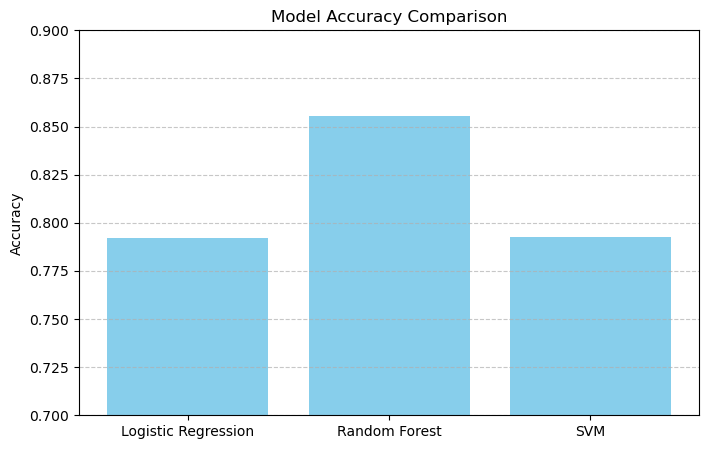

In [224]:
import matplotlib.pyplot as plt

model_names = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies = [0.7919, 0.8555, 0.7924]

plt.figure(figsize=(8,5))
plt.bar(model_names, accuracies, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [225]:
df.shape

(31140, 15)


# finding null values

In [226]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital_status    0
occupation        0
relationship      0
race              0
gender            0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
experience        0
dtype: int64

In [227]:
print(df.workclass.value_counts())

3    21871
5     2358
1     2039
2     1577
6     1278
4     1069
0      948
Name: workclass, dtype: int64


In [228]:

df.workclass.replace({'?':'Others'},inplace=True)
print('Workclass')
print(df['workclass'].value_counts())

Workclass
3    21871
5     2358
1     2039
2     1577
6     1278
4     1069
0      948
Name: workclass, dtype: int64


In [229]:
df

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income,experience
2,66,2,186061,12,6,8,4,2,0,0,4356,40,39,0,14
3,54,3,140359,3,0,6,4,4,0,0,3900,40,39,0,7
4,41,3,264663,12,5,10,3,4,0,0,3900,40,39,0,20
5,34,3,216864,9,0,7,4,4,0,0,3770,45,39,0,38
6,38,3,150601,0,5,0,4,4,1,0,3770,40,39,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,3,310152,12,4,11,1,4,1,0,0,40,39,0,13
32557,27,3,257302,5,2,13,5,4,0,0,0,38,39,0,0
32558,40,3,154374,9,2,6,0,4,1,0,0,40,39,1,3
32559,58,3,151910,9,6,0,4,4,0,0,0,40,39,0,17


In [230]:
print(df['workclass'].value_counts())

3    21871
5     2358
1     2039
2     1577
6     1278
4     1069
0      948
Name: workclass, dtype: int64


In [231]:
print(df['education'].value_counts())

9     10240
12     7126
7      5243
10     1676
6      1352
1      1120
5      1036
0       895
3       592
11      550
4       496
2       422
8       392
Name: education, dtype: int64


In [232]:
print(df['marital_status'].value_counts())

2    14293
4    10293
0     4343
5      982
6      837
3      371
1       21
Name: marital_status, dtype: int64


In [233]:
print(df.occupation.value_counts())

10    4029
2     3984
3     3981
0     3699
12    3553
7     3078
6     1894
8     1577
14    1530
5     1295
13     918
4      861
11     625
9      108
1        8
Name: occupation, dtype: int64


In [234]:
df.occupation.replace({'?':'Others'},inplace=True)

# Finding and handling outliers

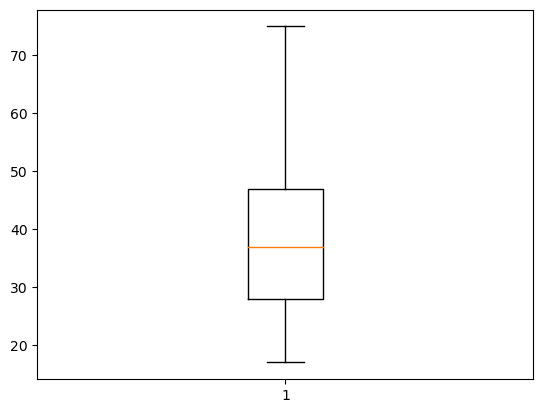

In [235]:
plt.boxplot(df['age'])
plt.show()

In [236]:
df=df[(df['age']<=75) & (df['age']>=17)]

In [237]:
# Outliers removing/ dataset cleaning by mutual understanding

In [238]:
df.workclass.value_counts()


3    21871
5     2358
1     2039
2     1577
6     1278
4     1069
0      948
Name: workclass, dtype: int64

In [239]:
# in the above code 'without-pay and 'never-worked' having very less count as well as they are not earning
# so not required for income prediction
# so we can remove such data
df=df[df['workclass']!='Without-pay']
df=df[df['workclass']!='Never-worked']


In [240]:
df.shape

(31140, 15)

In [241]:
# here also we can eliminate some categories like '1st-4th','5th-6th','Preschool'
df = df[~df['education'].isin(['1st-4th', '5th-6th', 'Preschool'])]


In [242]:
df.shape

(31140, 15)

In [243]:
# now the 'education' and 'education-num' are giving us same information so we will keep only one of them
# here i will remove the text data column 'education'

df.columns


Index(['age', 'workclass', 'fnlwgt', 'education', 'marital_status',
       'occupation', 'relationship', 'race', 'gender', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'income',
       'experience'],
      dtype='object')

In [244]:
df

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income,experience
2,66,2,186061,12,6,8,4,2,0,0,4356,40,39,0,14
3,54,3,140359,3,0,6,4,4,0,0,3900,40,39,0,7
4,41,3,264663,12,5,10,3,4,0,0,3900,40,39,0,20
5,34,3,216864,9,0,7,4,4,0,0,3770,45,39,0,38
6,38,3,150601,0,5,0,4,4,1,0,3770,40,39,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,3,310152,12,4,11,1,4,1,0,0,40,39,0,13
32557,27,3,257302,5,2,13,5,4,0,0,0,38,39,0,0
32558,40,3,154374,9,2,6,0,4,1,0,0,40,39,1,3
32559,58,3,151910,9,6,0,4,4,0,0,0,40,39,0,17


In [245]:
# as we know the algorithm is a mathematical expression so it cannot work on text data
# so we have to convert text data collumns in to numerical for that we will use encoder

In [246]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['workclass']=encoder.fit_transform(df['workclass'])
df['marital.status']=encoder.fit_transform(df['marital_status'])
df['occupation']=encoder.fit_transform(df['occupation'])
df['relationship']=encoder.fit_transform(df['relationship'])
df['race']=encoder.fit_transform(df['race'])
df['gender']=encoder.fit_transform(df['gender'])
df['native_country']=encoder.fit_transform(df['native_country'])
df

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income,experience,marital.status
2,66,2,186061,12,6,8,4,2,0,0,4356,40,39,0,14,6
3,54,3,140359,3,0,6,4,4,0,0,3900,40,39,0,7,0
4,41,3,264663,12,5,10,3,4,0,0,3900,40,39,0,20,5
5,34,3,216864,9,0,7,4,4,0,0,3770,45,39,0,38,0
6,38,3,150601,0,5,0,4,4,1,0,3770,40,39,0,18,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,3,310152,12,4,11,1,4,1,0,0,40,39,0,13,4
32557,27,3,257302,5,2,13,5,4,0,0,0,38,39,0,0,2
32558,40,3,154374,9,2,6,0,4,1,0,0,40,39,1,3,2
32559,58,3,151910,9,6,0,4,4,0,0,0,40,39,0,17,6


In [247]:
# spliting data in to X(independent variable) and Y (dependent variable)

In [248]:
X=df.drop(columns=['income'])
Y=df['income']
X

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,experience,marital.status
2,66,2,186061,12,6,8,4,2,0,0,4356,40,39,14,6
3,54,3,140359,3,0,6,4,4,0,0,3900,40,39,7,0
4,41,3,264663,12,5,10,3,4,0,0,3900,40,39,20,5
5,34,3,216864,9,0,7,4,4,0,0,3770,45,39,38,0
6,38,3,150601,0,5,0,4,4,1,0,3770,40,39,18,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,3,310152,12,4,11,1,4,1,0,0,40,39,13,4
32557,27,3,257302,5,2,13,5,4,0,0,0,38,39,0,2
32558,40,3,154374,9,2,6,0,4,1,0,0,40,39,3,2
32559,58,3,151910,9,6,0,4,4,0,0,0,40,39,17,6


In [249]:
Y

2        0
3        0
4        0
5        0
6        0
        ..
32556    0
32557    0
32558    1
32559    0
32560    0
Name: income, Length: 31140, dtype: int32

In [250]:
# scaller will convert entire data in one range that is 0 to 1

In [251]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X

array([[0.84482759, 0.33333333, 0.11802067, ..., 0.95121951, 0.35897436,
        1.        ],
       [0.63793103, 0.5       , 0.08698198, ..., 0.95121951, 0.17948718,
        0.        ],
       [0.4137931 , 0.5       , 0.17140354, ..., 0.95121951, 0.51282051,
        0.83333333],
       ...,
       [0.39655172, 0.5       , 0.09650032, ..., 0.95121951, 0.07692308,
        0.33333333],
       [0.70689655, 0.5       , 0.09482688, ..., 0.95121951, 0.43589744,
        1.        ],
       [0.0862069 , 0.5       , 0.12849934, ..., 0.95121951, 0.8974359 ,
        0.66666667]])

In [252]:

print(df['income'].value_counts())



0    23463
1     7677
Name: income, dtype: int64


In [253]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import joblib

X = df[['age', 'education', 'occupation', 'hours_per_week', 'experience']]
y = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC()
}

results = []
best_model = None
best_score = 0

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))
    print("-" * 50)
    
    if acc > best_score:
        best_score = acc
        best_model = pipe
        best_model_name = name



# here random_state=True suggest that the records getting choosen for trainning
# and testing will be in random order
# statify=Y we use only for classification task
# statify maintans the catagorical ratio in output column(Y) while getting choosen for trainning and testing

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
predict=knn.predict(X_test)
predict

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predict)

0.7724791265253693

In [ ]:
# from sklearn.model_selection import GridSearchCV
# knn=KNeighborsClassifier(n_jobs=-1)
# param_grid={
#     'n_neighbors':[3,5,7],
#     'weights':['uniform', 'distance'],
#     'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
# }
# gsv=GridSearchCV(knn,param_grid,n_jobs=-1,refit=True)
# gsv.fit(xtrain,ytrain)
# prediction=gsv.predict(xtest)
# print(gsv.best_params_)
# print(gsv.best_score_)
# print(accuracy_score(ytest,prediction))

In [ ]:
print (df.columns)

Index(['age', 'workclass', 'fnlwgt', 'marital_status', 'occupation',
       'relationship', 'race', 'gender', 'capital_gain', 'capital_loss',
       'hours_per_week', 'native_country', 'income', 'experience',
       'marital.status'],
      dtype='object')
